In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage import transform
from PIL import Image
from skimage.color import rgb2gray
import pickle
import torch

plt.rcParams["figure.figsize"] = (8,8)

In [2]:
imagefolderpath = 'Polytion/Testing'
LRpath = imagefolderpath + '/test_LRimages.pickle'
HRpath = imagefolderpath + '/test_HRimages.pickle'
try:
    with open(LRpath, 'rb') as handle:
        LRimages = pickle.load(handle)
    with open(HRpath, 'rb') as handle:
        HRimages = pickle.load(handle)
except ImportError:
    print("Image files don't exist")

In [3]:
num = 20

# Benchmark - RRDN vs Polytion

## RRDN - State of the art Super Resulution

**Pre-process images**

In [4]:
#convert images to RGB using matplotlib
d=512
s = 4
dpi = 72
d_new = round(d/s)
num=len(LRimages)
LRimages_RGB = []
filename = 'Polytion/Testing/test_fig.png'
figsize = d_new / float(dpi), d_new / float(dpi)

for n in range(num):
    #Save image using matplotlib to convert to RGB png image format necessary for RDN
    fig = plt.figure(figsize=figsize)
    plt.imshow(LRimages[n], cmap='gist_gray')

    #remove white spaces
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.savefig(filename)
    plt.close(fig)

    #load open the saved LR image
    im = Image.open(filename) 
    im = im.convert('RGB')
    im = np.asarray(im)
    LRimages_RGB.append(im)
       
LRimages_RGB = np.asarray(LRimages_RGB)
LRimages_RGB.shape

(107, 128, 128, 3)

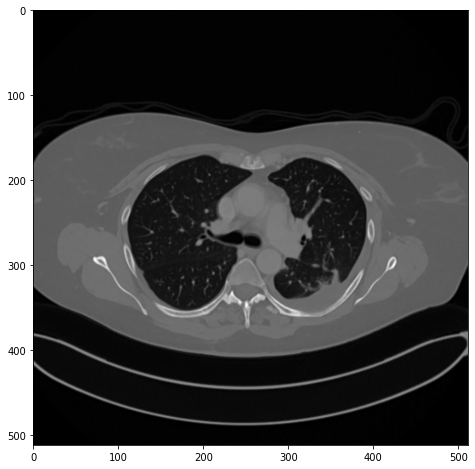

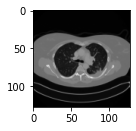

In [5]:
plt.imshow(HRimages[15],cmap='gist_gray')
plt.show()
plt.figure(figsize=figsize)
plt.imshow(LRimages_RGB[15],cmap='gist_gray')
plt.show()

### Predict image
Use pre-trained RRDN model

Implementation of the Residual in Residual Dense Network for image super-scaling.
The network is the one described in https://arxiv.org/abs/1809.00219 (Wang et al. 2018).

In [6]:
from ISR.models import RRDN
from PIL import Image
model_rrdn = RRDN(weights='gans')

In [7]:
# PREDICT one sample
# im_sr = model.predict(np.array(LRimages_RGB[0]))
# im_sr = np.array(im_sr)
# im_sr = rgb2gray(im_sr) #flatten to 1 chanell
# print(im_sr.shape)
# plt.imshow(im_sr)
# plt.show()

In [8]:
#PREDICT all samples
images_sr = []
images_lr = LRimages_RGB[:num]

for i in range(num):
    im_sr = model_rrdn.predict(np.array(images_lr[i]))
    im_sr = np.array(im_sr)
    im_sr = rgb2gray(im_sr) #flatten to 1 chanell
    images_sr.append(im_sr)

images_sr = np.asarray(images_sr)
images_sr.shape

(107, 512, 512)

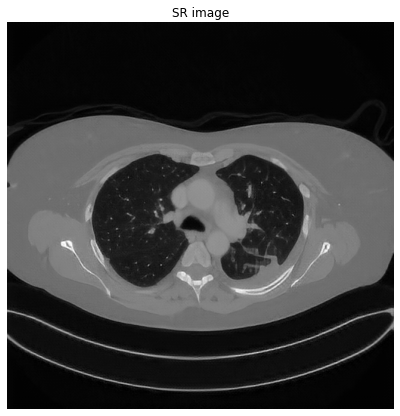

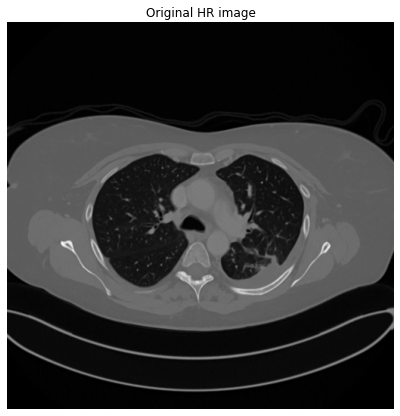

In [9]:
n = 10
fake = images_sr[n]
real = HRimages[n]
#fake_upscaled = transform.resize(fake,(d, d))

height, width = fake.shape
figsize = width / float(dpi), height / float(dpi)
plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(fake,cmap='gist_gray')
plt.title("SR image")
plt.show()


plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(real,cmap='gist_gray')
plt.title("Original HR image")
plt.show()

## 2. Polytion

## CP model

In [10]:
from Polytion import Generator as g
from Polytion import AutoEncoderNet as AE

In [11]:
modelname = "Polytion/Testing/Trained_CP_model.pth"
modelparamsname = "Polytion/Testing/Trained_CP_model_params.pth"

mp = torch.load(modelparamsname)
model_CP = AE.Autoencoder_seq(mp["layer"], mp["N"], mp["rank"], mp["bottleneck_dim"], mp["HR_dim"], mp["downscalefactor"], mp["scalefactor"], mp["layerOptions"], mp["generatorOptions"])
model_CP.load_state_dict(torch.load(modelname))

<All keys matched successfully>

In [12]:
# Test:
#index = 4
images_sr_cp = []
model_CP.eval()

for i in range(num):
    test = torch.tensor(LRimages[i]).reshape(1,1,mp["LR_dim"],mp["LR_dim"])
    output = model_CP(test).reshape(mp["HR_dim"], mp["HR_dim"]).detach().numpy()
    images_sr_cp.append(output)

/zhome/30/c/134708/.local/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


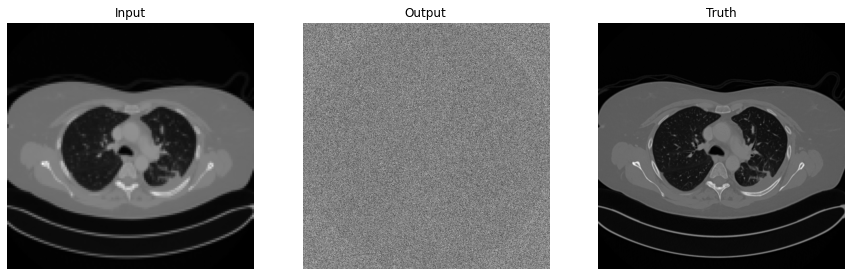

In [13]:
index = 10
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(LRimages[index], cmap='gray')
ax[0].set_title("Input")
ax[0].axis('off')

ax[1].imshow(images_sr_cp[index], cmap='gray')
ax[1].set_title("Output")
ax[1].axis('off')

ax[2].imshow(HRimages[index], cmap='gray')
ax[2].set_title("Truth")
ax[2].axis('off')
plt.show()

## Image Quality metrics

#### PSNR 
Typical values for the PSNR in lossy image and video compression are between 30 and 50 dB, higher the better
![oo](https://wikimedia.org/api/rest_v1/media/math/render/svg/fc22801ed1232ff1231c4156b589de5c32063a8a)

#### SSIM 
formula is based on three comparison measurements: luminance, contrast and structure.    
It is a decimal value between -1 and 1, and value 1 is only reachable in the case of two identical sets of data and therefore indicates perfect structural similarity. A value of 0 indicates no structural similarity. For an image, it is typically calculated using a sliding Gaussian window of size 11x11 or a block window of size 8×8.

In [14]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import mean_squared_error as mse

### RRDN

In [15]:
num = 20
res = np.zeros((4,num))
for i in range(num):
    res[0,i] = ssim(images_sr[i], HRimages[i])
    res[1,i] = psnr(images_sr[i], HRimages[i])
    res[2,i] = nrmse(images_sr[i], HRimages[i])
    res[3,i] = mse(images_sr[i], HRimages[i])
    
    
metrics = ['ssim','psnr','nrmse','mse']
res_mean = res.mean(axis=1)

print("SSIM: %s"%res_mean[0])
print("psnr: %s"%res_mean[1])
print("nrmse: %s"%res_mean[2])
print("mse: %s"%res_mean[3])   

SSIM: 0.8863872359142521
psnr: 25.12650983894016
nrmse: 0.18263658708755598
mse: 0.0031368590732563165


In [16]:
# x = np.asarray(range(0,num))
# fig, ax = plt.subplots(4,1,figsize=(15,10))
# plt.subplots_adjust(hspace=0.5)
# ax[0].set_title("Image quality metrics per sample")
# ax[0].plot(x,res[0],label=metrics[0])
# ax[0].legend(loc="upper right")
# ax[1].plot(x,res[1],label=metrics[1])
# ax[1].legend(loc="upper right")
# ax[2].plot(x,res[2],label=metrics[2])
# ax[2].legend(loc="upper right")
# ax[3].plot(x,res[3],label=metrics[3])
# ax[3].legend(loc="upper right")

# plt.show()

### Polytion CP

In [20]:
from Polytion import prepData as prep
images_sr_cp = prep.normalize_0(images_sr_cp)


res2 = np.zeros((4,num))
for i in range(num):
    res2[0,i] = ssim(images_sr_cp[i], HRimages[i])
    res2[1,i] = psnr(images_sr_cp[i], HRimages[i])
    res2[2,i] = nrmse(images_sr_cp[i], HRimages[i])
    res2[3,i] = mse(images_sr_cp[i], HRimages[i])
    
    
metrics = ['ssim','psnr','nrmse','mse']
res_mean_2 = res2.mean(axis=1)

print("SSIM: %s"%res_mean_2[0])
print("psnr: %s"%res_mean_2[1])
print("nrmse: %s"%res_mean_2[2])
print("mse: %s"%res_mean_2[3])   

/zhome/30/c/134708/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  import sys
/zhome/30/c/134708/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


SSIM: 0.09127263312738418
psnr: 7.985940823734334
nrmse: 0.7709752124747498
mse: 0.1590050312453905


### Compare metrics across models

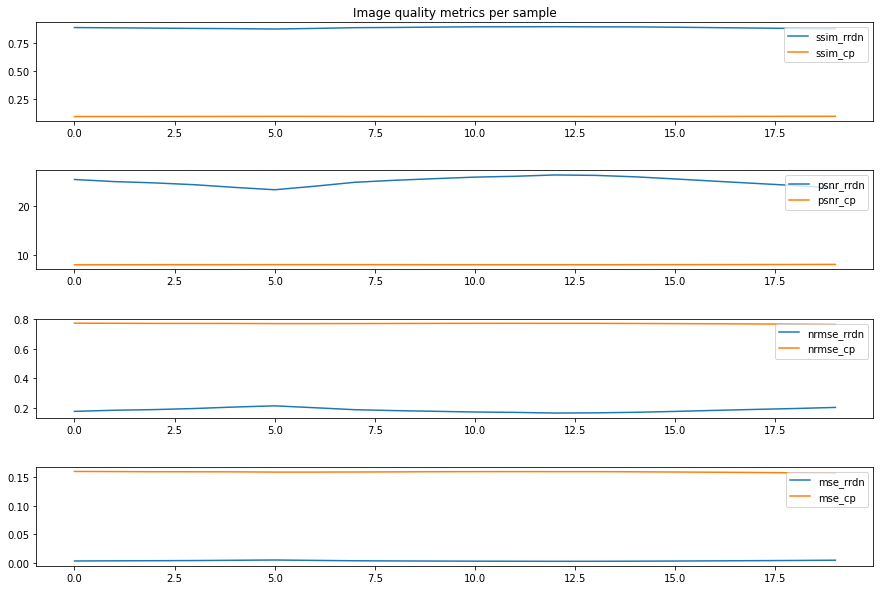

In [18]:
x = np.asarray(range(0,num))
fig, ax = plt.subplots(4,1,figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
ax[0].set_title("Image quality metrics per sample")
ax[0].plot(x,res[0],label=metrics[0]+ "_rrdn")
ax[0].plot(x,res2[0],label=metrics[0]+ "_cp")
ax[0].legend(loc="upper right")
ax[1].plot(x,res[1],label=metrics[1]+ "_rrdn")
ax[1].plot(x,res2[1],label=metrics[1]+ "_cp")
ax[1].legend(loc="upper right")
ax[2].plot(x,res[2],label=metrics[2]+ "_rrdn")
ax[2].plot(x,res2[2],label=metrics[2]+ "_cp")
ax[2].legend(loc="upper right")
ax[3].plot(x,res[3],label=metrics[3]+ "_rrdn")
ax[3].plot(x,res2[3],label=metrics[3]+ "_cp")
ax[3].legend(loc="upper right")

plt.show()